In [26]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [27]:
def metrics(y_test, y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)

  TN = conf_matrix[0, 0]
  FP = conf_matrix[0, 1]
  FN = conf_matrix[1, 0]
  TP = conf_matrix[1, 1]

  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)

  return conf_matrix, sensitivity, specificity

#Decision Tree


Implementation of decision tree learning based on entropy reduction, assuming that the probability of a class occurrence is directly proportional to the proportion of occurrences of its samples
in the dataset.


**Node class:** This class represents nodes in the decision tree. Nodes can either be internal nodes (decision nodes) or leaf nodes (terminal nodes). Internal nodes contain information about features and thresholds for splitting, as well as references to their left and right child nodes. Leaf nodes store the predicted value for a subset of data.



In [28]:
class Node():

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):

        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

**DecisionTree class:**

- **split_data method:** This method splits the dataset into two subsets based on a specified feature and threshold.

- **entropy:** This function calculates the entropy of a given set of labels using the formula $$H(S) = - \sum_{i=1}^{n} p_i \log_2(p_i),$$ where $p_i$ is the probability of occurrence of each class label $i$ in the dataset $S$.

- **information_gain:** This function calculates the information gain by finding the difference between the entropy of the parent node and the weighted average of the entropies of its children nodes. It uses the formula $$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v),$$ where:
  *   $S$ is the dataset,
  *   $A$ is the attribute,
  *   $S_v$ are the subsets of $S$ for each value $v$ of attribute $A$.


- **best_split:** This function finds the best split for a dataset by iterating through all features and their unique values to calculate the information gain. It returns the feature index, threshold, and the two resulting datasets that maximize the information gain.

- **calculate_leaf_value:** This function calculates the value for a leaf node. It finds the most occurring label in the given set of labels and assigns it as the leaf value.

- **build_tree:** This function recursively builds the decision tree by finding the best split at each node based on the information gain. It stops recursion when either minimum samples or maximum depth criteria are met. It returns the root node of the decision tree.

- **fit:** This function fits the decision tree to the training data. It constructs the dataset by concatenating features and labels and then builds the tree using the 'build_tree' function.

- **predict:** This function predicts the labels for the input data samples using the trained decision tree. It iterates through each sample and makes predictions by traversing the tree until a leaf node is reached.

- **make_prediction:** This function predicts the label for a single input sample by traversing the decision tree until a leaf node is reached. It returns the label assigned to the leaf node.

In [29]:
class DecisionTree():

    def __init__(self, min_samples=2, max_depth=2):

        self.min_samples = min_samples
        self.max_depth = max_depth

    def split_data(self, dataset, feature, threshold):

        left_dataset = []
        right_dataset = []

        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def entropy(self, y):

        entropy = 0
        labels = np.unique(y)
        for label in labels:
            label_examples = y[y == label]
            pl = len(label_examples) / len(y)
            entropy += -pl * np.log2(pl)
        return entropy

    def information_gain(self, parent, left, right):

        information_gain = 0
        parent_entropy = self.entropy(parent)
        weight_left = len(left) / len(parent)
        weight_right= len(right) / len(parent)
        entropy_left, entropy_right = self.entropy(left), self.entropy(right)
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        information_gain = parent_entropy - weighted_entropy
        return information_gain


    def best_split(self, dataset, num_samples, num_features):

        best_split = {'gain':- 1, 'feature': None, 'threshold': None}
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                if len(left_dataset) and len(right_dataset):
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    information_gain = self.information_gain(y, left_y, right_y)
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split


    def calculate_leaf_value(self, y):

        y = list(y)
        most_occuring_value = max(y, key=y.count)
        return most_occuring_value

    def build_tree(self, dataset, current_depth=0):

        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            best_split = self.best_split(dataset, n_samples, n_features)
            if best_split["gain"]:
                left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
                return Node(best_split["feature"], best_split["threshold"],
                            left_node, right_node, best_split["gain"])

        leaf_value = self.calculate_leaf_value(y)
        return Node(value=leaf_value)

    def fit(self, X, y):

        dataset = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):

        predictions = []
        for x in X:
            prediction = self.make_prediction(x, self.root)
            predictions.append(prediction)
        np.array(predictions)
        return predictions

    def make_prediction(self, x, node):

        if node.value != None:
            return node.value
        else:
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)

A function that allows us to draw our trees:

In [30]:
def tree_plot(node, depth=0, xmin=-2, xmax=2):
    if node is None:
        return

    if node.feature is not None:
        x_center = (xmin + xmax) / 2
        y_center = depth

        x_left = xmin if node.left is None else (xmin + x_center) / 2
        x_right = xmax if node.right is None else (xmax + x_center) / 2

        offset = 0.3
        threshold_rounded = round(node.threshold, 3)  # Zaokrąglanie do 3 miejsc po przecinku
        plt.text(x_center, y_center, f"Feature {node.feature} \n <=  {threshold_rounded}", ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

        if node.left is not None:
            plt.arrow(x_center, y_center, x_left - x_center, -0.8, head_width=0.1, head_length=0.1, fc='black', ec='black')
            plt.text(x_left, y_center - 1, f"class:\n{node.left.value}", ha='center', va='center')
            tree_plot(node.left, depth - 1, xmin, x_center)

        if node.right is not None:
            plt.arrow(x_center, y_center, x_right - x_center, -0.8, head_width=0.1, head_length=0.1, fc='black', ec='black')
            plt.text(x_right, y_center - 1, f"class:\n{node.right.value}", ha='center', va='center')
            tree_plot(node.right, depth - 1, x_center, xmax)

We already have everything we need, so we can start testing:

##Synthetic Single-Mode Dataset:

In [31]:
X, y = make_classification(n_samples=2568, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=254468)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [32]:
model = DecisionTree(min_samples=2, max_depth=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

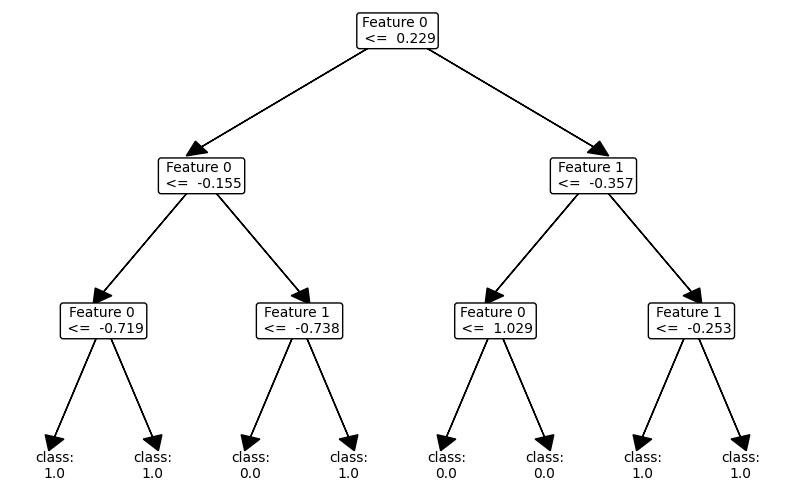

In [33]:
plt.figure(figsize=(10, 6))
tree_plot(model.root)
plt.axis('off')
plt.show()

In [34]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred)

print("conf_matrix:")
print(conf_matrix_anl)
print("sensitivity:", sensitivity_anl)
print("specificity:", specificity_anl)

conf_matrix:
[[379   6]
 [  2 384]]
sensitivity: 0.9948186528497409
specificity: 0.9844155844155844


##Multi-Mode Dataset

In [35]:
X_multi, y_multi = make_classification(n_samples=2568, n_features=2, n_informative=2, n_redundant=0,
                                        n_clusters_per_class=2, random_state=254468)

X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.3, random_state=254468)

In [36]:
model = DecisionTree(min_samples=5, max_depth=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

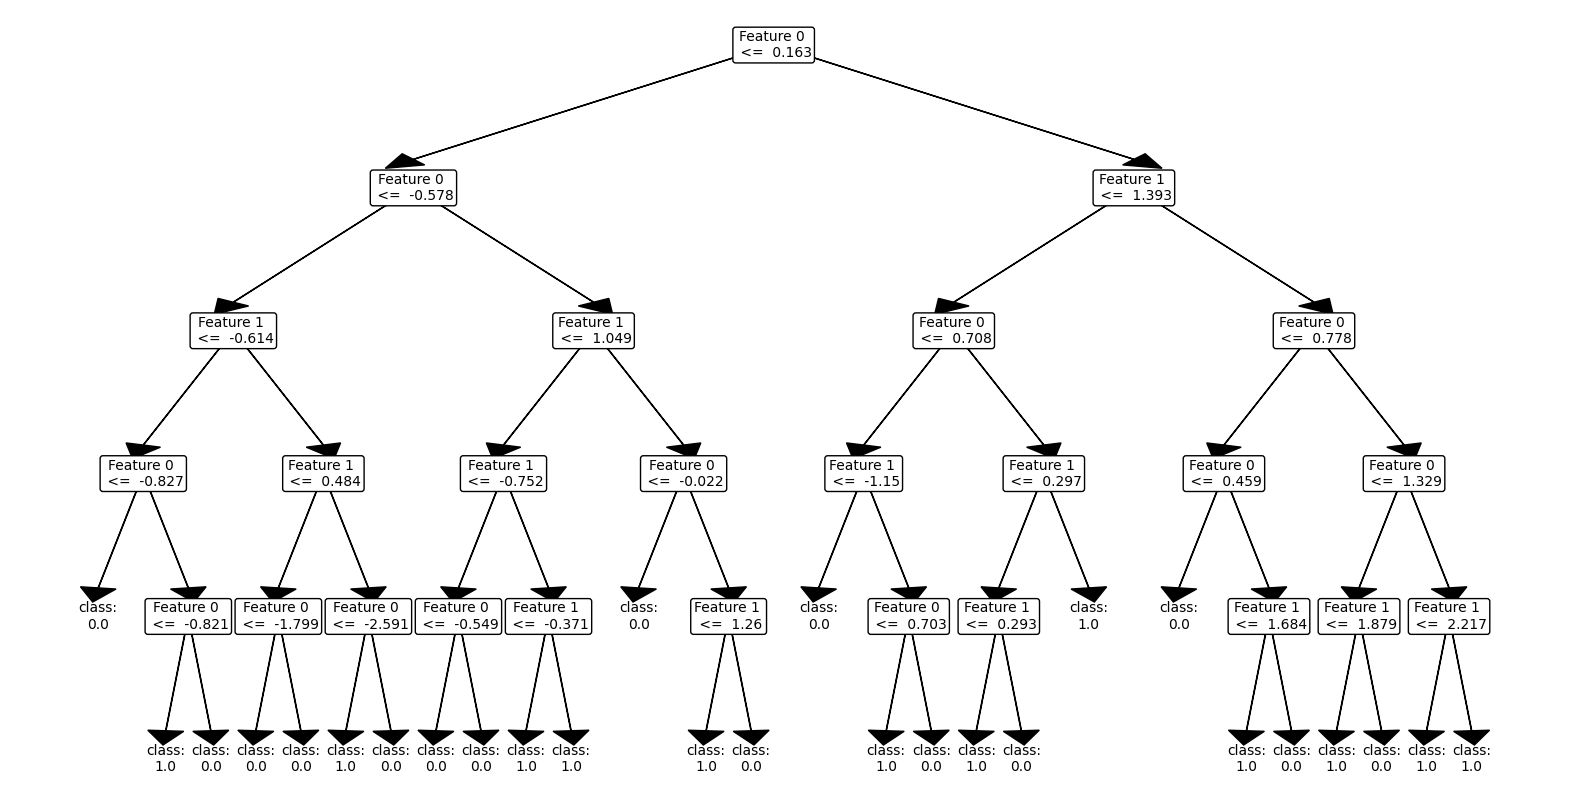

In [37]:
plt.figure(figsize=(20, 10))
tree_plot(model.root)
plt.axis('off')
plt.show()

In [38]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred)

print("conf_matrix:")
print(conf_matrix_anl)
print("sensitivity:", sensitivity_anl)
print("specificity:", specificity_anl)

conf_matrix:
[[345  45]
 [ 26 355]]
sensitivity: 0.931758530183727
specificity: 0.8846153846153846


In both cases, the model performed very well